In [2]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install scikit-beam
#!{sys.executable} -m pip install numba

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit as fit
import scipy.sparse as sci_sparse

import os

from dls_data_extraction import*

#%matplotlib notebook

[1.35750647e-04 2.25528200e+02 1.65853387e+00]


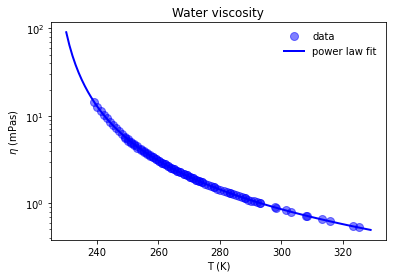

In [3]:
ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',') # mPas, water viscosity from dehaoui et al.
ndata_w2 = np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat', delimiter=',') # mPas, macroscopic water viscosity 
ndata_w = np.vstack((ndata_w1,ndata_w2))

popt_w,pcov_w = fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4, 220, 2]) # Pas
print(popt_w)

T_range = np.linspace(230,330,100) # K

plt.figure()
plt.plot(ndata_w[:,0],ndata_w[:,1],'o',c='b',alpha=0.5,ms=8,label='data')
plt.plot(T_range[0:-1],power_law(T_range[0:-1],*popt_w)*1e3,c='b',ls='-',lw=2 ,label='power law fit')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\eta$ (mPas)')
plt.title(r'Water viscosity')
plt.legend(frameon=False)
#plt.xlim([290,330])
#plt.ylim([0,2])
plt.yscale('log')

#plt.savefig('water_viscosity.png') # save plot

plt.show()

## scattering volume

In [31]:
d = 1e-3/2          # half beam path through sample, m
w0 = 88e-9/2        # half beam waist, m
divergence = 1.2e-3 # divergence, rad
w1 = 0.5 * 2 * d * np.tan(divergence/2) + w0   # half-beam width at sample edges, m 
#w1 = d * divergence/2 # half-beam width at sample edges, m 
print('beam width at edges (w1) [um]:', 2*w1*1e6)

photon_energy = 10.0e3 # eV
h = 4.135667516e-15
c = 2.99792458e8
wavelength = h*c / photon_energy # m
zR = w0    #np.pi * w0**2 / wavelength # Rayleigh length, m
#print('Rayleigh length [um]:', zR*1e6)

# large cone for the divergent beam away from the focal plane
V1 = 1/3 * np.pi * w1**2 * d # m^3

# small cone (the tip of the larger cone)
V2 = 1/3 * np.pi * w0**2 * zR # m^3

Vd = (V1-V2)
#Vd = V1
print('Vd [fL]:', Vd*1e3*1e15)

# approximate volume close to beam waist (within Rayleigh length zR)
VR = np.pi * w0**2 * zR # m^3 
print('VR [fL]:', 2*VR*1e3*1e15)

# total illuminated volume
Vs = 2*(Vd + VR) # times 2 to account for both sides of the focal plane, m^3
#Vs = 2*Vd # times 2 to account for both sides of the focal plane, m^3

print('Scattering volume [fL]:', Vs*1e3*1e15) # [m^3] * [l/m^3] * [pl/l] = pl

beam width at edges (w1) [um]: 0.6880000720000102
Vd [fL]: 61.960508473221076
VR [fL]: 0.0005352268572067858
Scattering volume [fL]: 123.92155217329935


## average number of particles in the scattering volume 

In [33]:
#d = 100e-9
#w1 = 2 * d * np.tan(divergence/2) + w0 # beam width at sample edges, m
#R = w1/2 # m, beam radius
#dz = 1e-3 # m, beam path
#Vs = np.pi*R**2*dz  # scattering volume (slice)
print('Scattering volume [fL]', Vs*1e3*1e15)

Rp = 48e-9      # m, particle radius
Rh = 63e-9      # m, effective hydrodynamic radius
c = 0.48/100    # particle volume fraction in pure water 
c = 0.16/100   # particle volume fraction in dmso-water
#c = 0.1/100   # particle volume fraction, lower limit

Vp = 4*np.pi*Rp**3/3 # particle volume
print('Particle volume [fL]', Vp*1e3*1e15)

N = c*Vs/Vp        # number of particles in the scattering volume
print('Number of particles in the scattering volume (N):', N)

# diffusion coefficient for brownian motion
T = 295 # K
k = 1.38064852e-23
D = k*T/(6*np.pi*Rh*power_law(T,*popt_w))  # SE diffusion coefficient
print('D =', D)

#S = 2*np.pi*R*d # surface area of the scattering volume
#S/D             # average time spent in scattering volume, s

# time required for particles to diffuse distance w
#print('time at to travel distance w0 [s]:', w0**2/D)
#print('time at to travel distance w1 [s]:', w1**2/D)

Scattering volume [fL] 123.92155217329935
Particle volume [fL] 0.0004632466863277365
Number of particles in the scattering volume (N): 428.0105812500174
D = 3.5839349328068737e-12


## g2 contributions

beam waist 88.0
D 3.4210287994974705e-12
2pi/q (nm):  89.75979010256552
theta [deg]: 0.07914202498006391
a (um): 157.39816648150733
Number fluctuations term:
1st factor: 0.0004262389948519771
2nd: 0.9992936751153461
3rd: 0.9999999999723823
tau_diff (us): 141.47790865458273
fitted D: 3.4156225086012366e-12


(0.5, 5000.0)

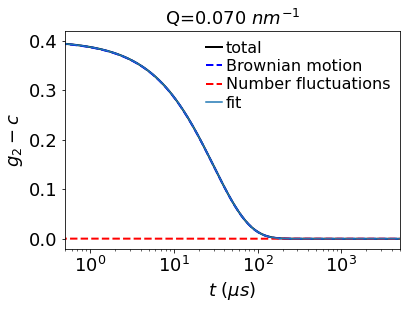

In [405]:
q = 0.07*1e9 # m^-1
print('beam waist', w0*2*1e9)
print('D', D)

tau = 1/(D*q**2)
print('2pi/q (nm): ', 2*np.pi/q*1e9)
#print('dynamic length scale (nm):', np.sqrt(6*D*tau)*1e9)

theta = 2*np.arcsin(q*wavelength/(4*np.pi))      # scattering angle, rad
print('theta [deg]:', theta*180/np.pi)

a = Vs/w0**2 * (np.pi/2)**(-3/2) * np.sin(theta) # radius of beam seen by the detector, m
print('a (um):', a*1e6)
#a = w0

t = np.logspace(-7,-1, 300) # delay time, s

##################################################

# number fluctuation term
gamma = 2**(-3/2)
#gamma = 2**(-1)
#N = 1

#Nfluct_term = gamma/N * (1 + 4*D*t/w0**2)**(-1) * (1 + 4*D*t/a**2)**(-1/2)
#Nfluct_term = 1/N * (1 + 4*D*t/w0**2)**(-1) * (1 + 4*D*t/a**2)**(-1/2) # gaussian-gaussian scattering volume FCS, a=gaussian width along beam path
Nfluct_term = gamma/N * (1 + 4*D*t/w0**2)**(-1) # scattering volume bounded by walls in the z direction at the points z = 0, L
print('Number fluctuations term:')
print('1st factor:', gamma/N)
print('2nd:', (1 + 4*D*t[0]/w0**2)**(-1))
print('3rd:', (1 + 4*D*t[0]/a**2)**(-1/2))
print('tau_diff (us):', w0**2/(4*D)*1e6)

# Brownian term
beta = 0.4
brownian_term = beta*np.exp(-2*D*q**2*t)

# total g2-1
g2 = brownian_term + Nfluct_term

# approximation of no fluctuation term
tau = 1e-3
alpha = 1
beta2 = 0.35
approx = beta2*(1+t/tau)**(-3/2) #np.exp(-(t/tau)**alpha)
approx = beta2*np.exp(-(t/tau)**alpha)

w = 88e-9/2
approx = beta2*np.exp(-(2*D*t/w**2))

def exponential(x, a , b):
    return np.abs(a)*np.exp(-2*x/np.abs(b)) #+ baseline

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, t, g2, p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
D1 = 1/(popt[1]*q**2)
print('fitted D:', D1)


##################################################

# plot
plt.figure()
plt.plot(t*1e6, g2, 'k-', lw=2, label='total')
plt.plot(t*1e6, brownian_term, 'b--', lw=2, label='Brownian motion')
plt.plot(t*1e6, Nfluct_term, 'r--', lw=2, label='Number fluctuations')
#plt.plot(t*1e6, approx, 'r--', alpha=0.5, lw=2, label='approx.')
plt.plot(t*1e6, exponential(t, *popt), linestyle='-', lw=1.5, label='fit')

plt.xlabel('$t ~(\mu s)$', size=18)
plt.ylabel(r'$g_2-c$', size=18)
plt.xscale('log', nonpositive='clip')
plt.legend(frameon=False, loc='upper right', fontsize=16, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.1)
plt.tick_params(labelsize=18)
plt.title(r'Q=%.3f $nm^{-1}$' %(q*1e-9), size=18)
plt.xlim([5e-7*1e6,5e-3*1e6])
#plt.ylim([-0.1,1.05])